In [11]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from numpy import exp,pi,power

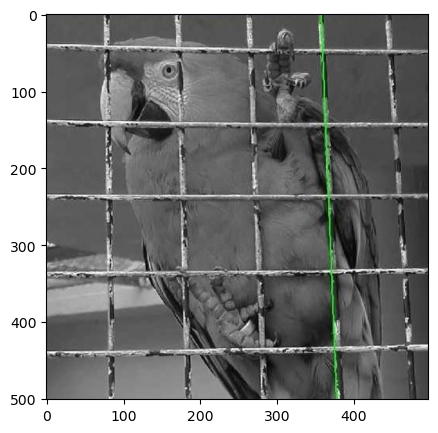

In [47]:
image = cv2.imread("./image/hough_1.jpg")
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


高斯核：
 [[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


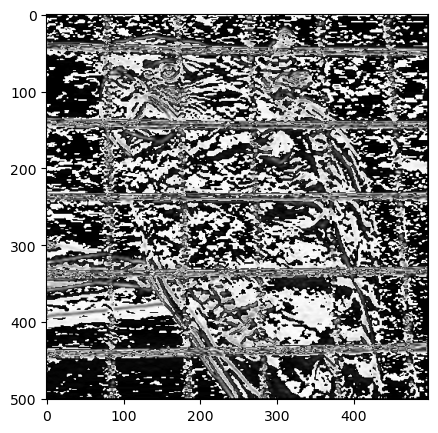

In [49]:
class Canny:
    g_kernel = None
    def __init__(self, g_dim = 5):
        # 初始化高斯核
        g_kernel = []
        for y in range(g_dim):
            row = []
            for x in range(g_dim):
                j, i = y - int(g_dim/2), x - int(g_dim/2)
                row.append(self.G_fun(i, j))
            g_kernel.append(row)
        g_kernel = np.array(g_kernel)
        g_kernel = g_kernel/g_kernel.sum()
        self.g_kernel = g_kernel
        print("高斯核：\n", g_kernel)
    def calculateEdges(self, image_gray, threshold_btm = 80, threshold_top = 100):
        '''
            计算边缘
        '''
        # 高斯滤波，边缘点为原图的值
        image_g = self.gaussian(image_gray)
        # 计算梯度幅值和梯度方向
        kerner_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        kerner_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        g_x = self.convolute(image_g,kerner_x)
        g_y = self.convolute(image_g,kerner_y)
        return g_y
    def gaussian(self,image_gray):
        image_g = self.convolute(image_gray, self.g_kernel,lambda y,x:image_gray[y,x])
        return image_g
    def G_fun(self,x,y,p = 1):
        return 1/(2*pi*power(p, 2))*exp((-power(x, 2)-power(y, 2))/(2*power(p, 2)))
    def convolute(self, image_gray, kernel, padding_method=lambda y, x: 0):
        '''
            卷积
        '''
        h,w = image_gray.shape
        k_h,k_w = kernel.shape
        k_h_half, k_w_half = int(k_h/2), int(k_w/2)
        image_dst = np.zeros_like(image_gray)
        for y,rows in enumerate(image_dst):
            for x,cell in enumerate(rows):
                if y - k_h_half < 0 or y + k_h_half > h-1 or x - k_w_half < 0 or x + k_w_half > w-1:
                    image_dst[y,x] = padding_method(y,x)
                else:
                    sum = 0
                    for j,k_rows in enumerate(kernel):
                        for i,k_cell in enumerate(k_rows):
                            sum = sum + k_cell * \
                                image_gray[y-k_h_half+j, x-k_w_half+i]
                    image_dst[y,x] = sum
        return image_dst


# 灰度化
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
canny = Canny()
# canny边缘检测
edges = canny.calculateEdges(image_gray, 80, 100)
edges_show = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(edges_show)
plt.show()
    


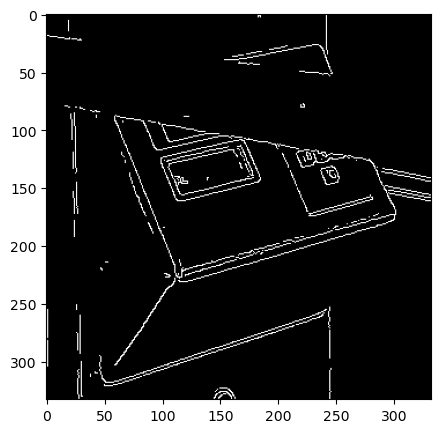

In [5]:
# opencv的canny边缘检测效果
edges = cv2.Canny(image, threshold1=80, threshold2=100)
edges_show = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(edges_show)
plt.show()